In [1]:
import numpy as np
import pandas as pd

from selenium import webdriver
import time
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

### Scraping reviews from the Amazon product page 

In [2]:
driver = webdriver.Chrome()

In [3]:
i = 0
review_text = []
review_rating = []

while True:
    i = i + 1
    url = "https://www.amazon.com/Zelvot-Adjustable-Hydration-Breathable-Reflective/product-reviews/B0D6YMKZ64/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber="+str(i)
    driver.get(url)
    time.sleep(5)
    data = BeautifulSoup(driver.page_source, "html.parser")
    reviews = data.find_all("div", {"data-hook":"review"})

    for review in reviews:
        text = review.find("span", {"data-hook":"review-body"}).text.strip()
        review_text.append(text)
        rating = review.find("span", {"class":"a-icon-alt"}).text[:3]
        review_rating.append(rating)

    if not reviews:
        break

driver.quit()

In [4]:
# checking results
review_text[:5]

["This vest is a very nice option for someone not looking break the bank. It comes with a bladder for hydration and the phone pocket fits my phone with it's case and pop socket! The material is comfortable and the best doesn't feel heavy when everything is loaded into it. The only con I find to this vest is that the straps can loosen up as you run. I had to tighten them a few times during last run.",
 'I previously ordered a running bus from a different vendor and it was nice, but I needed something a little bit more quality and black. I took a chance on this one and let me tell you for the price that I got it for it felt like an expensive Lululemon dupe! I love the pockets and the cell phone holder that it comes with. The fit is comfortable as well, not too tight and washed well.',
 'Love all of the pockets! Great fit. It does get loose easily while I’m running , but it’s easy to tighten up.',
 'i like this vest a lot! its super light and it fits perfectly on me.does not rub against m

In [5]:
review_rating[:5]

['5.0', '5.0', '4.0', '5.0', '5.0']

In [6]:
# checking total no of reviews
len(review_text)

74

We have correctly looped in all reviews for this product from all the available pages. 

### Crating our dataframe

In [7]:
reviews = pd.DataFrame({
    "review_text" : review_text,
    "review_rating" : review_rating
    })

### Data cleaning and exploratory analysis

In [8]:
reviews.head()

,review_text,review_rating
0,This vest is a very nice option for someone no...,5.0
1,I previously ordered a running bus from a diff...,5.0
2,Love all of the pockets! Great fit. It does ge...,4.0
3,i like this vest a lot! its super light and it...,5.0
4,so happy with my purchase!! It’s so lightweigh...,5.0


In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_text    74 non-null     object
 1   review_rating  74 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [10]:
reviews["review_rating"] = reviews["review_rating"].astype("float")
reviews["review_text"] = reviews["review_text"].apply(lambda x: x.strip())

In [11]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   review_text    74 non-null     object 
 1   review_rating  74 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.3+ KB


In [12]:
reviews.isna().any()

review_text      False
review_rating    False
dtype: bool

In [13]:
reviews.duplicated().any()

False

In [14]:
reviews.describe()

,review_rating
count,74.000000
mean,4.472973
std,0.879336
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


As a result, we have 73 reviews and an average rating of 4.46 stars.

The current rating (1 to 5 stars) provides an overall numerical assessment, while sentiment score analyzes the emotional content within text using ML. I will add the latter for a more nuanced analysis.

### Sentiment analysis with BERT pre-trained NLP model

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [16]:
# creating a tokenizer and calling in our pre-trained model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [17]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors="pt") # encoding each review
    result = model(tokens) # passing those tokens through our model to get our results
    return int(torch.argmax(result.logits))+1 # returning a sentiment score for each result (1 to 5)

In [18]:
# note: token limits for this model is 512
reviews["BERT_score"] = reviews["review_text"].apply(lambda x: sentiment_score(x[:512])) 

In [19]:
len(reviews["BERT_score"])

74

### Visualize results and compare product ratings to sentiment scores

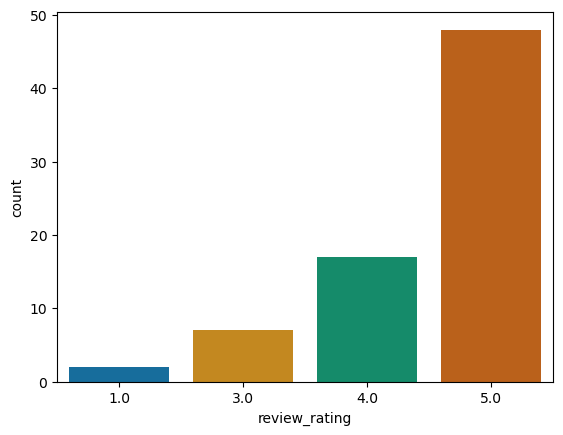

In [20]:
sns.countplot(x="review_rating", data=reviews, palette="colorblind", hue= "review_rating", legend=False)
plt.show()

In [21]:
reviews["review_rating"].value_counts(normalize=True) * 100

review_rating
5.0    64.864865
4.0    22.972973
3.0     9.459459
1.0     2.702703
Name: proportion, dtype: float64

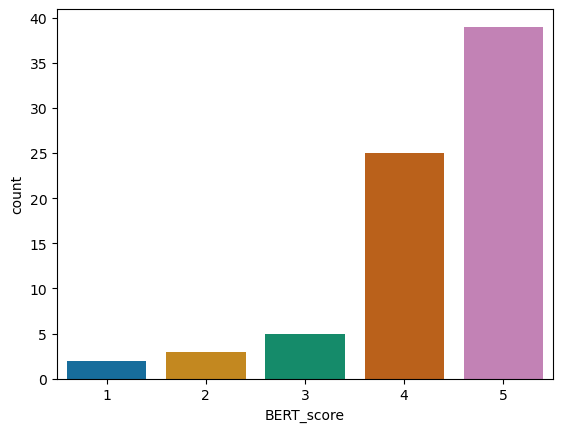

In [22]:
sns.countplot(x="BERT_score", data=reviews, palette="colorblind", hue= "BERT_score", legend=False)
plt.show()

In [23]:
reviews["BERT_score"].value_counts(normalize=True) * 100

BERT_score
5    52.702703
4    33.783784
3     6.756757
2     4.054054
1     2.702703
Name: proportion, dtype: float64

In [24]:
reviews["review_rating"].corr(reviews["BERT_score"])

0.6254443550312793

We notice a moderately strong positive linear relationship between review_rating and BERT_score. 

Now let"s see an example of a nuanced sentence: 5 star review with the most negative nuance according to our BERT model

In [25]:
reviews.loc[reviews["review_rating"] == 5].sort_values("BERT_score", ascending=True).head()

,review_text,review_rating,BERT_score
20,I hate running with a phone and water bottle i...,5.0,1
67,The vest is comfortable on the tightest settin...,5.0,2
0,This vest is a very nice option for someone no...,5.0,4
60,Reflection is great. A small water bottle. S...,5.0,4
47,I really like this hydration vest. It has adj...,5.0,4


Review no. 20 seems to have a very negative sentiment score with a 5-star review: let"s investigate this further:

In [26]:
reviews["review_text"].loc[20]

'I hate running with a phone and water bottle in my pockets! My shorts swaying with the weight of a phone and water bottle is so annoying! Amazon exists and I found this product to help me run! I don’t have to hold my phone and water because this vest does it for me!'

In this case, the model picked on the negative feelings expressed by the user towards running without a vest, a problem solved by this product. Hence, the 5-star rating score makes sense to us. 

Let's see the second 5-star review with low BERT score:

In [27]:
reviews["review_text"].loc[66]

'I use this on my daily running with my son. Keeps everything safe and secure'

This is a great example of a nuanced review as it suggests there might be a sizing issue. This should be further investigated. 
Feedback is also provided regarding comfort issues when using the vest in warm weather.

Positive feedback concerns the customer service, which sent a product replacement. This likely convinced the customer to give 5-star rating. 

### Reviews' keyword visualization 

In [28]:
from wordcloud import WordCloud

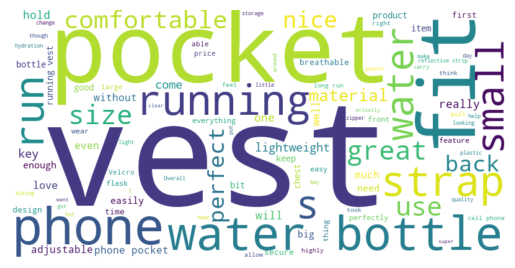

In [29]:
text = " ".join(reviews["review_text"])
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We can see mostly positive mentions such as *comfortable, great, perfect, lightweight, good quality*.

A few negative mentions such as *small*.

We also notice trending words referring to the product's features: *pocket, phone (holder), front pouch, water (holder), reflective strip*.

### Issue categorization using targeted keywords on reviews

For this analysis, we are interested in issues related to size (especially after our keyword analysis) and faulty items, as well as overall perception of the product as too expensive.

In [30]:
def categorize_review(review):
    if "too big" in review or "too small" in review:
        return "size"
    elif "expensive" in reviews or "pricy" in review:
        return "price too high"
    elif "broken" in reviews or "faulty" in review:
        return "faulty item"
    else:
        return "none"

reviews["issue"] = reviews["review_text"].apply(categorize_review)    

In [31]:
reviews["issue"].value_counts() 

issue
none    68
size     6
Name: count, dtype: int64

Based on our few selected key words, only 4% of reviews mention an issue, which is the size. However, when we take a closer look, we can see that the product rating is still pretty high and so is the sentiment score. I would conclude that it's not a big issue, but it is advised to check this further.

In [32]:
reviews.loc[reviews["issue"] != "none"]

,review_text,review_rating,BERT_score,issue
13,This vest is nice and easy to use. It has plen...,5.0,5,size
31,"This is nice, however I order L/XL and it is t...",4.0,4,size
32,This vest has a lot of potential that might ma...,4.0,4,size
33,First thing to note: this item does precisely ...,4.0,4,size
36,This would be perfect for anyone looking for a...,4.0,3,size
57,It looked a little too small at first but it f...,5.0,5,size


In [33]:
# exporting our dataframe as a csv file
reviews.to_csv("product_reviews.csv")